In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
import tensorflow as tf
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 114922607428392408
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3576356864
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2383221545600156314
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
2.10.1


angry
disgust
fear
happy
neutral
sad
surprise


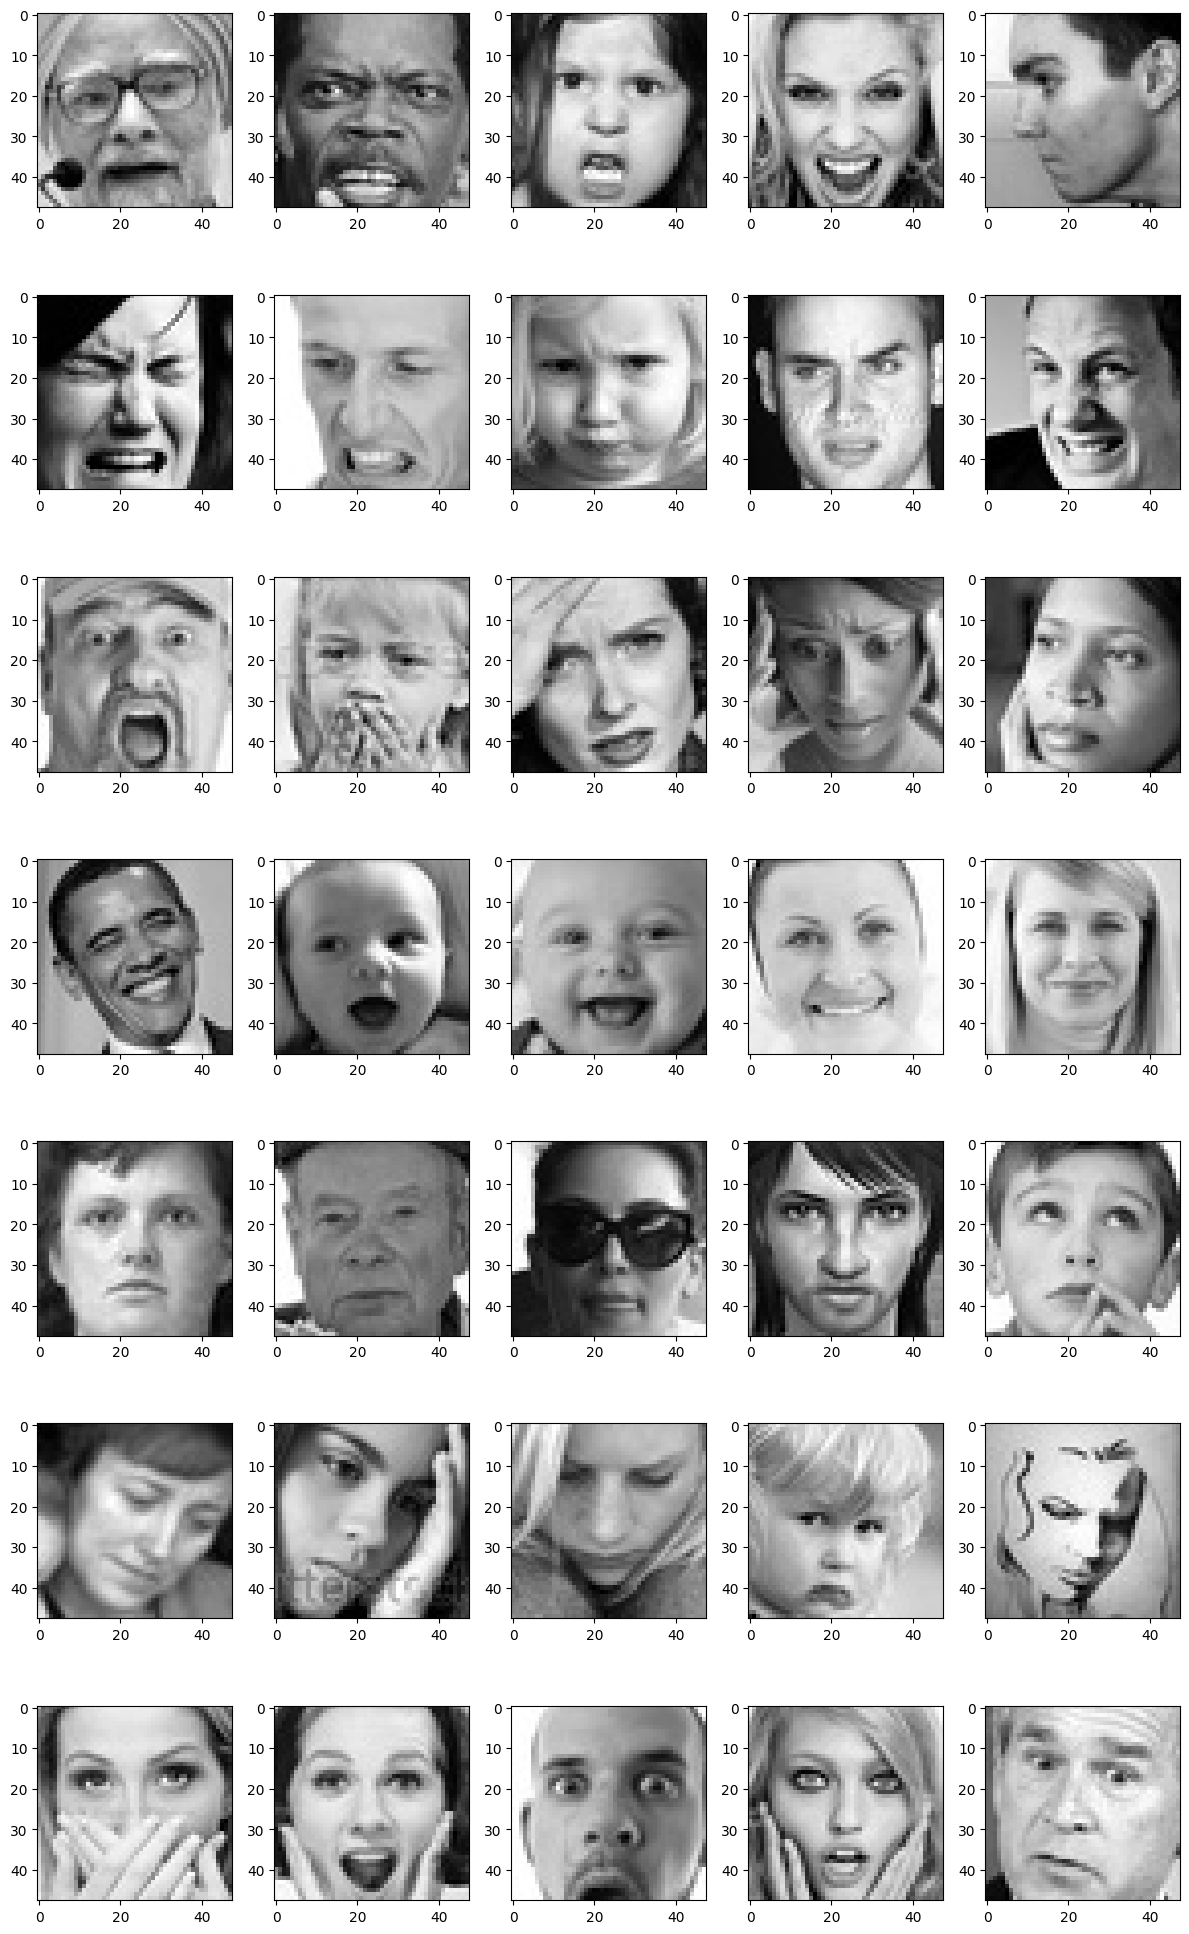

In [3]:
from PIL import Image
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import os
# from keras.preprocessing.image import load_img, img_to_array

emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

img_path_train = '../datasets/train/'
img_path_validation = '../datasets/validation/'
plt.figure(0, figsize=(12,20))
pic_size = 48
cnt = 0
for expression in emotions:
    print(expression)
    for i in range(1,6):
        cnt = cnt + 1
        plt.subplot(7,5,cnt)
        img = Image.open(img_path_train + expression + '/' +os.listdir(img_path_train + expression)[i], 'r')
        plt.imshow(img, cmap="gray")
plt.tight_layout()
plt.show()



In [4]:
# building data generator 

from keras.preprocessing.image import ImageDataGenerator

batch_size = 128


train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale= 1.0/255)

train_generator = train_datagen.flow_from_directory(img_path_train,
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(img_path_validation,
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [5]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

#Convolution 1
model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1)))
model.add(Activation('relu'))

#Convolution 2
model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1)))
model.add(Activation('relu'))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(nb_classes, activation='softmax'))

print(model.summary())

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 64)        640       
                                                                 
 activation (Activation)     (None, 56, 56, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 56, 56, 64)        0         
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 256)               51380480  
                                                                 
 activation_2 (Activation)   (None, 256)               0

In [6]:
# number of epochs to train the NN
epochs = 4

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
with tf.device('/gpu:0'):
    history = model.fit_generator(generator=train_generator,
                                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                                    epochs=epochs,
                                    validation_data = validation_generator,
                                    validation_steps = validation_generator.n//validation_generator.batch_size,
                                    callbacks=callbacks_list
                                    )

C:\Users\Woodkid\AppData\Local\Temp\ipykernel_7376\1086250433.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/4
225/225 [==============================] - ETA: 0s - loss: 1.9193 - accuracy: 0.2448
Epoch 1: val_accuracy improved from -inf to 0.29148, saving model to model_weights.h5
225/225 [==============================] - 41s 145ms/step - loss: 1.9193 - accuracy: 0.2448 - val_loss: 1.7566 - val_accuracy: 0.2915
Epoch 2/4
225/225 [==============================] - ETA: 0s - loss: 1.7468 - accuracy: 0.2870
Epoch 2: val_accuracy improved from 0.29148 to 0.33977, saving model to model_weights.h5
225/225 [==============================] - 23s 102ms/step - loss: 1.7468 - accuracy: 0.2870 - val_loss: 1.6826 - val_accuracy: 0.3398
Epoch 3/4
225/225 [==============================] - ETA: 0s - loss: 1.7167 - accuracy: 0.3095
Epoch 3: val_accuracy improved from 0.33977 to 0.37315, saving model to model_weights.h5
225/225 [==============================] - 18s 80ms/step - loss: 1.7167 - accuracy: 0.3095 - val_loss: 1.6366 - val_accuracy: 0.3732
Epoch 4/4
225/225 [==============================]

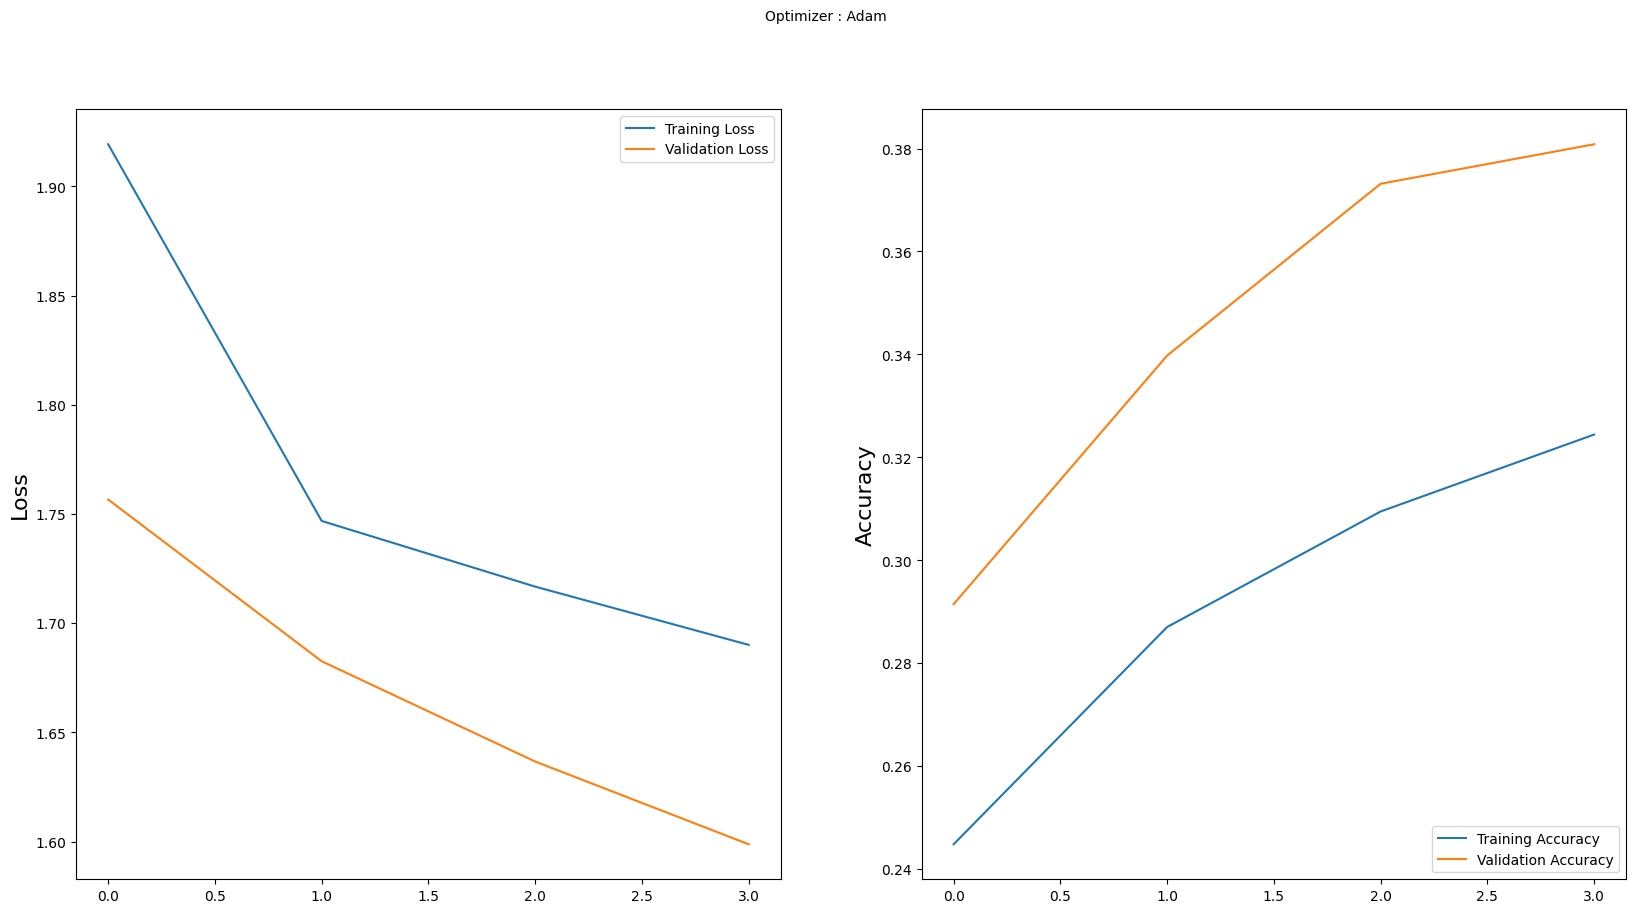

In [7]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()